## Kalman Filter and curve fitting - Carlos J. Arguello, Ph.D.

Kalman filter is a special case of bayesian estimator where the value of a hidden process/variable is estimated using the input of noisy sensors. This technique has 
applications in diverse fields such as navigation, control systems, finance and forecasting.

In the Kalman filtering algorithm, the state space equations are linear, and the noise terms have a normal distribution.

## Example 1: Recursive linear regression.

Let's tackle the usual linear regression problem. We have a set of observations  $D = [(x_1, y_1), (x_2,y_2) ... (x_N,y_N)]$. Let's assume the following statistical model for the data:

$$y(x) = \theta_1x+\theta_2+\omega \qquad \omega \sim N(0,\sigma^2)$$

The goal is to estimate the value of the parameters $\theta_1$ and $\theta_2$ given the set $[D]$ of observations.

This is of course, the well known problem of ordinary linear squares, with the solution:
$$\hat{\theta} = (X^TX)^{-1}X^Ty$$

Where X is the design matrix (N observations, k regressors + intercept):

$$ X =
\begin{bmatrix}
    1 & x_{11} & x_{12} & x_{13} & \dots  & x_{1k} \\
    1 & x_{21} & x_{22} & x_{23} & \dots  & x_{2k} \\
    1 & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{N1} & x_{N2} & x_{N3} & \dots  & x_{Nk}
\end{bmatrix}
$$

The normal equation gives the best estimate of the regressor weights given the complete dataset. As new data is obtained, the entire regression has to be recalculated. 

Kalman filtering gives an algorithm to recursively calculate the best estimator given the current data. This corresponds to calculating (using Bayes' Theorem):

$$p(\theta | y_{1:N}) \propto p(y_N|\theta)p(\theta|y_{1:T-1})$$

In order to improve reusability, for the Kalman filter code I define the following class:

In [141]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Class for Kalman Filter:

class KalmanFilter:
    def __init__(self, x0, P0):
        self.x = np.asmatrix(x0).transpose()
        self.P = np.asmatrix(P0)
    
    def predict(self, F, Q):
        F= np.asmatrix(F)
        Q = np.asmatrix(Q)
        self.x = F*self.x
        self.P = Q + F*self.P*F.transpose()
    
    def update(self,H,R,y):
        H = np.asmatrix(H)
        R = np.asmatrix(R)
        #temp_sigma = (self.P**(-1) + H.transpose()*R**(-1)*H)**(-1)
        innov = y - H*self.x
        S = R + H*self.P*H.transpose()
        K = self.P*H.transpose()*S**(-1)
        self.x = self.x + K*innov 
        self.P = self.P - K*H*self.P
        #self.x = temp_sigma*(self.P**(-1)*self.x + H.transpose()*R**(-1)*y)
        #self.P = temp_sigma  

Let's also define a class for our model:

In [9]:
class Model:
    def __init__(self, theta1, theta2, measurement_error):
        self.theta1 = theta1
        self.theta2 = theta2
        self.error = measurement_error
    def measure(self, x):
        return self.theta1*x+self.theta2+np.random.normal(0,self.error,1)

We expect to obtain one data point at a time. We would like to see how our estimate for $\theta$ improves as we obtain more points. Let's first suppose that $\theta_1 = 2, \theta_2 = 1.4142$. Our noisy measurements have a normal distribution with $\sigma = 0.1$: 

In [138]:
model1 = Model(2,1,0.1)

We take sequential measurements, and use the Kalman filter to estimate $\theta$ as new data comes in. For the Kalman filter, we need an initial guess for our paramenters $\theta = [1.,1.]$ and of our uncertainty of these parameters ($\sigma_{\theta_1}^2 = 0.2, \sigma_{\theta_2}^2 = 0.2$)

In [186]:
kf_model1 = KalmanFilter([1,0], np.identity(2)*0.2)

Now, we take 500 measurements:

In [150]:
point_estimate = []
estimate_variance = []
for n in range(500):
    point_estimate.append(np.asarray(kf_model1.x.transpose()).flatten())
    estimate_variance.append([kf_model1.P[0,0], kf_model1.P[1,1]])
    x = np.random.uniform()
    y = model1.measure(x)
    kf_model1.update([x, 1],0.1,y) #Only the update step of Kalman filter, not the predict step since the parameters are time independent.

Now, lets check how the estimates for theta converge to the true values (2,1):

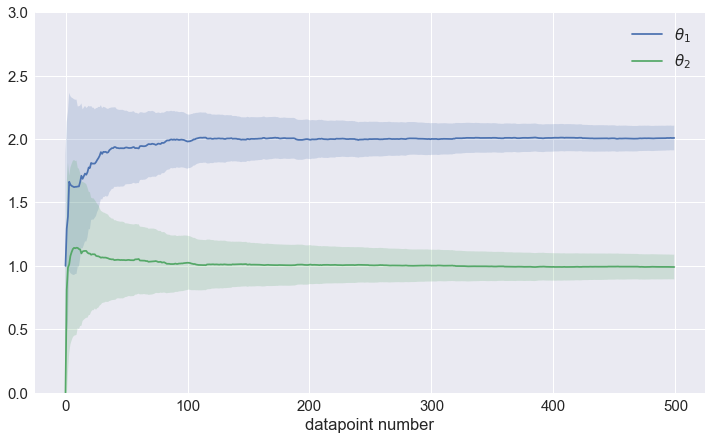

In [151]:
sns.set_context("notebook", font_scale=1.5)
theta1 = [theta[0] for theta in point_estimate]
theta2 = [theta[1] for theta in point_estimate]
theta1_ci_lo = [scipy.stats.norm.interval(0.95, loc=theta1[x], 
                                          scale = estimate_variance[x][0]**(0.5))[0] for x in range(len(theta1))]
theta1_ci_hi = [scipy.stats.norm.interval(0.95, loc=theta1[x], 
                                          scale = estimate_variance[x][0]**(0.5))[1] for x in range(len(theta1))]
theta2_ci_lo = [scipy.stats.norm.interval(0.95, loc=theta2[x], 
                                          scale = estimate_variance[x][0]**(0.5))[0] for x in range(len(theta1))]
theta2_ci_hi = [scipy.stats.norm.interval(0.95, loc=theta2[x], 
                                          scale = estimate_variance[x][0]**(0.5))[1] for x in range(len(theta1))]
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(theta1, label = r'$\theta_1$')
ax.fill_between(range(len(theta1)), theta1_ci_lo, theta1_ci_hi, alpha = 0.2)
ax.plot(theta2, label = r'$\theta_2$')
ax.fill_between(range(len(theta1)), theta2_ci_lo, theta2_ci_hi, alpha = 0.2)
ax.set_xlabel('datapoint number')
ax.set_ylim(0,3);
ax.legend(loc='best')
plt.show()

We can see how as the datapoint number increases, the estimate of $\theta$ gets closer to the true parameters. The shaded area shows the 0.95 predictive interval for the parameters.

## Example 2: Linear regression with parameter drift

In the usual linear regression, we expect the parameters to be constant. However we can generalize for the case where the parameters change between iterations. The statistical model of an example where the parameters follow a random walk can be expressed as:

$$y(t) = \theta_1t+\theta_2+\omega \qquad \omega \sim N(0,R)$$
$$\theta_t = \theta_{t-1} + \nu \qquad \nu \sim N(0,Q)$$

We can use the same Kalman filter formulation to estimate the parameters as function of time. Lets see this in an example. 

Assume that we want to track a noisy sinusoidal function with this process. Let $y(t) = 2sin(2\pi t) + \omega$, where $\omega$ is the noise term (this could be the measurement of a position of a pendulum). A realization of the measurement is shown below: 

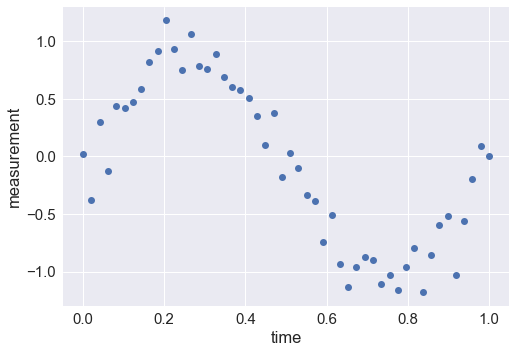

In [203]:
x_obs = np.linspace(0,1,50)
y_obs = np.sin(2*np.pi*x)+np.random.normal(0,0.2,50)
plt.plot(np.linspace(0,1,50),y, 'o')
ax = plt.gca()
ax.set_xlabel('time')
ax.set_ylabel('measurement')
plt.show()

What is our best estimate for the actual position of the pendulum based on our linear statistical model? Lets use a Kalman filter for this:

In [212]:
kf_model2 = KalmanFilter([1,0], 0.2*np.identity(2))

In [213]:
point_estimate = []
estimate_variance = []
for n, y in enumerate(y_obs):
    point_estimate.append(np.asarray(kf_model2.x.transpose()).flatten())
    estimate_variance.append([kf_model2.P[0,0], kf_model2.P[1,1]])
    kf_model2.predict(np.identity(2), 0.2*np.identity(2))
    kf_model2.update([x_obs[n], 1], 0.2, y)

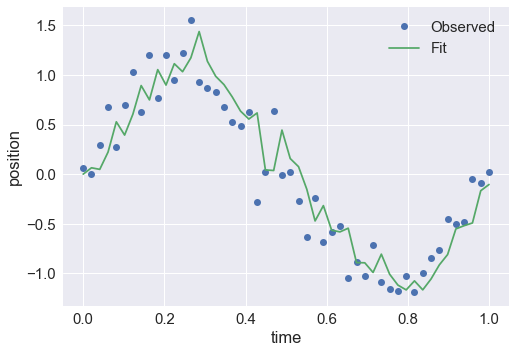

In [216]:
plt.plot(x_obs,y_obs, 'o', label = 'Observed')
plt.plot(np.linspace(0,1,50), np.linspace(0,1,50)*[z[0] for z in point_estimate]+[z[1] for z in point_estimate], label = 'Fit')
ax = plt.gca()
ax.set_xlabel('time')
ax.set_ylabel('position')
ax.legend(loc='best')
plt.show()